# How to optimize controls in arbitrary quantum systems using graphs
**Highly-configurable non-linear optimization framework for quantum control**

Boulder Opal provides a highly-flexible optimization engine for general-purpose gradient-based optimization.
It can be directly applied to model-based control optimization for arbitrary-dimensional quantum systems.

The optimization engine from Boulder Opal allows the user to express their system Hamiltonians as almost-arbitrary functions of the controllable parameters.
The underlying structure of this map is a [graph](https://docs.q-ctrl.com/boulder-opal/topics/understanding-graphs-in-boulder-opal), which defines the cost function and can be efficiently evaluated and differentiated.
The resulting optimized controls thus achieve the desired objectives within the constraints imposed by the user-defined Hamiltonian structure.

The example in this user guide illustrates how to optimize multiple controls under different constraints in a single system.
For a step-by-step description of how to create a robust optimization with multiple controls, see our tutorial [Design robust single-qubit gates using computational graphs](https://docs.q-ctrl.com/boulder-opal/tutorials/design-robust-single-qubit-gates-using-computational-graphs).

## Summary workflow
### 1. Define the computational graph
The Boulder Opal optimization engine expresses all optimization problems as [data flow graphs](https://docs.q-ctrl.com/boulder-opal/topics/understanding-graphs-in-boulder-opal), which you can create a graph object by initializing the `boulderopal.Graph` class.
The methods of the graph object allow you to represent the mathematical structure of the problem that you want to solve.

For an optimization, a typical workflow is to:
- Create "signals", or scalar-valued functions of time, which typically represent control pulses.
- Create "operators", or matrix-valued functions of time, by modulating constant operators by signals. These typically represent terms of a Hamiltonian.
- Combine the operators into a single Hamiltonian operator.
- Calculate the optimization cost function (typically an infidelity) from the Hamiltonian.

### 2. Execute graph-based optimization

You can calculate an optimization from an input graph using the `boulderopal.run_optimization` function.
Provide the name of the node of the graph that represents the cost, and this function will return the optimized value of the output nodes that you requested.

## Example: Optimal control of a single qubit

This example shows how to optimize a Hamiltonian with multiple controls.
Specifically, consider a single-qubit system represented by the following Hamiltonian:

\begin{align*}
H(t) &= \frac{\nu}{2} \sigma_{z} + \frac{1}{2}\left[\gamma(t)\sigma_{-} + \gamma^*(t)\sigma_{+}\right] + \frac{\alpha(t)}{2} \sigma_{z} , 
\end{align*}

where $\nu$ is the qubit detuning, $\gamma(t)$ and $\alpha(t)$ are, respectively, complex and real time-dependent pulses, $\sigma_{\pm}$ are the qubit ladder operators, and $\sigma_{z}$ is the Pauli-Z operator.

The functions of time $\gamma(t)$ and $\alpha(t)$ are not predetermined, and instead are optimized by Boulder Opal in order to achieve the target operation, which in this case is a Y-gate.

In [1]:
import numpy as np
import qctrlvisualizer as qv
import boulderopal as bo

Your task (action_id="1828657") has started.
Your task (action_id="1828657") has completed.
Optimized cost:	5.129e-13


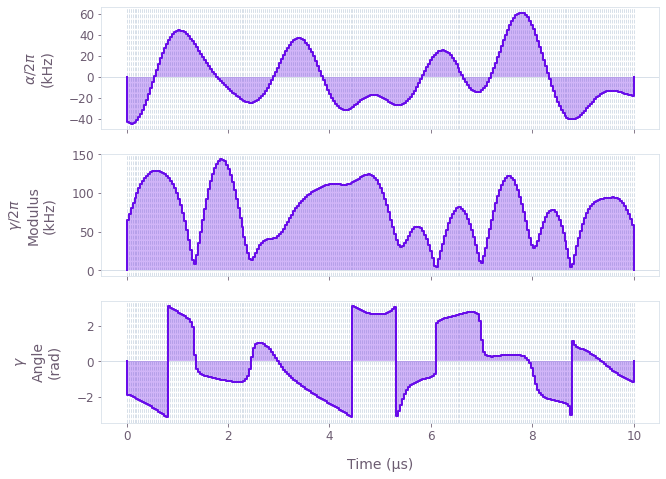

In [2]:
# Define physical constants.
nu = 2 * np.pi * 5e5  # rad/s
gamma_max = 2 * np.pi * 3e5  # rad/s
alpha_max = 2 * np.pi * 1e5  # rad/s
cutoff_frequency = 5e6  # Hz
segment_count = 50
duration = 10e-6  # s

# Create the graph describing the system.
graph = bo.Graph()

# Create the time-independent detuning term.
detuning = nu * graph.pauli_matrix("Z") / 2

# Create a optimizable complex-valued piecewise-constant (PWC) signal.
rough_gamma = graph.complex_optimizable_pwc_signal(
    segment_count=segment_count, maximum=gamma_max, duration=duration
)
# Smooth the signal.
gamma = graph.filter_and_resample_pwc(
    pwc=rough_gamma,
    segment_count=256,
    kernel=graph.sinc_convolution_kernel(cutoff_frequency),
    name=r"$\gamma$",
)

# Create a PWC operator representing the drive term.
drive = graph.hermitian_part(gamma * graph.pauli_matrix("M"))

# Create an optimizable real-valued PWC signal.
rough_alpha = graph.real_optimizable_pwc_signal(
    segment_count=segment_count,
    minimum=-alpha_max,
    maximum=alpha_max,
    duration=duration,
)
# Smooth the signal.
alpha = graph.filter_and_resample_pwc(
    pwc=rough_alpha,
    segment_count=256,
    kernel=graph.sinc_convolution_kernel(cutoff_frequency),
    name=r"$\alpha$",
)
# Create a PWC operator representing the clock shift term.
shift = alpha * graph.pauli_matrix("Z") / 2

# Define the total Hamiltonian and the target operation.
hamiltonian = detuning + drive + shift
target = graph.target(graph.pauli_matrix("Y"))

# Create the infidelity.
infidelity = graph.infidelity_pwc(hamiltonian, target, name="infidelity")

# Run the optimization.
result = bo.run_optimization(
    graph=graph,
    cost_node_name="infidelity",
    output_node_names=[r"$\alpha$", r"$\gamma$"],
    optimization_count=4,
)
print(f"Optimized cost:\t{result['cost']:.3e}")

# Plot the optimized controls.
qv.plot_controls(result["output"])